In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim

: 

In [2]:
import pandas as pd

df = pd.read_csv("team_traditional.csv")
df = df[df["season"] >= 2024].reset_index(drop=True)

df = df[[
    "gameid", "date", "team", "home", "away",
    "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%",
    "FTM", "FTA", "FT%", "OREB", "DREB", "REB",
    "AST", "TOV", "STL", "BLK", "PF"
]].copy()

df["is_home"] = (df["team"] == df["home"]).astype(int)

home = df[df["is_home"] == 1].copy()
away = df[df["is_home"] == 0].copy()

games = home.merge(away, on="gameid", suffixes=("_home", "_away"))

games = games.rename(columns={
    "team_home": "home_team",
    "team_away": "away_team",
    "PTS_home": "home_PTS",
    "PTS_away": "away_PTS"
})

games["date"] = pd.to_datetime(games["date_home"])
games = games.sort_values("date")

games["home_last5_pts"] = games.groupby("home_team")["home_PTS"].transform(
    lambda x: x.rolling(5, min_periods=1).mean()
)

games["away_last5_pts"] = games.groupby("away_team")["away_PTS"].transform(
    lambda x: x.rolling(5, min_periods=1).mean()
)

games["TOTAL_POINTS"] = games["home_PTS"] + games["away_PTS"]

final_df = games[[
    "gameid", "date",
    "home_team", "away_team",
    "home_PTS", "away_PTS",
    "FGM_home", "FGA_home", "FG%_home", "3PM_home", "3PA_home", "3P%_home",
    "FTM_home", "FTA_home", "FT%_home",
    "OREB_home", "DREB_home", "REB_home",
    "AST_home", "TOV_home", "STL_home", "BLK_home", "PF_home",
    "FGM_away", "FGA_away", "FG%_away", "3PM_away", "3PA_away", "3P%_away",
    "FTM_away", "FTA_away", "FT%_away",
    "OREB_away", "DREB_away", "REB_away",
    "AST_away", "TOV_away", "STL_away", "BLK_away", "PF_away",
    "home_last5_pts", "away_last5_pts",
    "TOTAL_POINTS"
]]

final_df.head(), final_df.shape

(      gameid       date home_team away_team  home_PTS  away_PTS  FGM_home  \
 0   22300061 2023-10-24       DEN       LAL     119.0     107.0      48.0   
 1   22300062 2023-10-24       GSW       PHX     104.0     108.0      36.0   
 13  22300074 2023-10-25       LAC       POR     123.0     111.0      47.0   
 12  22300073 2023-10-25       SAS       DAL     119.0     126.0      46.0   
 11  22300072 2023-10-25       UTA       SAC     114.0     130.0      41.0   
 
     FGA_home  FG%_home  3PM_home  ...  DREB_away  REB_away  AST_away  \
 0       91.0      52.7      14.0  ...       31.0      44.0      23.0   
 1      101.0      35.6      10.0  ...       43.0      60.0      23.0   
 13      90.0      52.2      16.0  ...       25.0      40.0      20.0   
 12      89.0      51.7      11.0  ...       35.0      48.0      24.0   
 11      91.0      45.1       9.0  ...       30.0      45.0      29.0   
 
     TOV_away  STL_away  BLK_away  PF_away  home_last5_pts  away_last5_pts  \
 0       12.

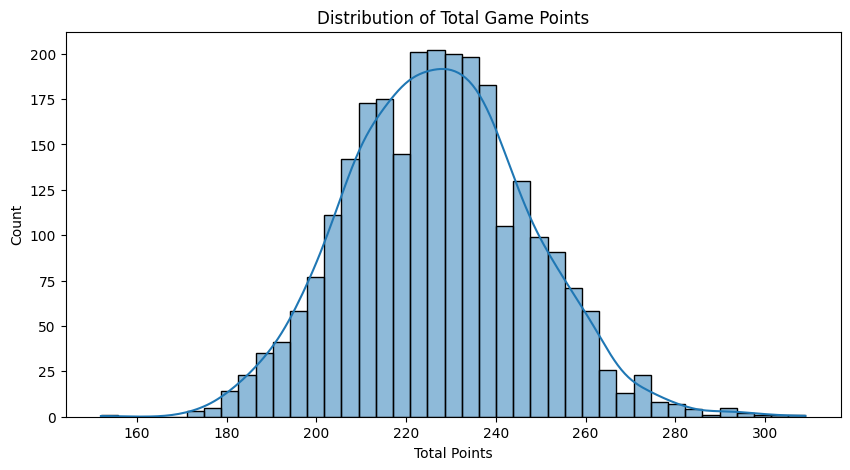

In [3]:
plt.figure(figsize=(10,5))
sns.histplot(final_df["TOTAL_POINTS"], kde=True)
plt.title("Distribution of Total Game Points")
plt.xlabel("Total Points")
plt.show()

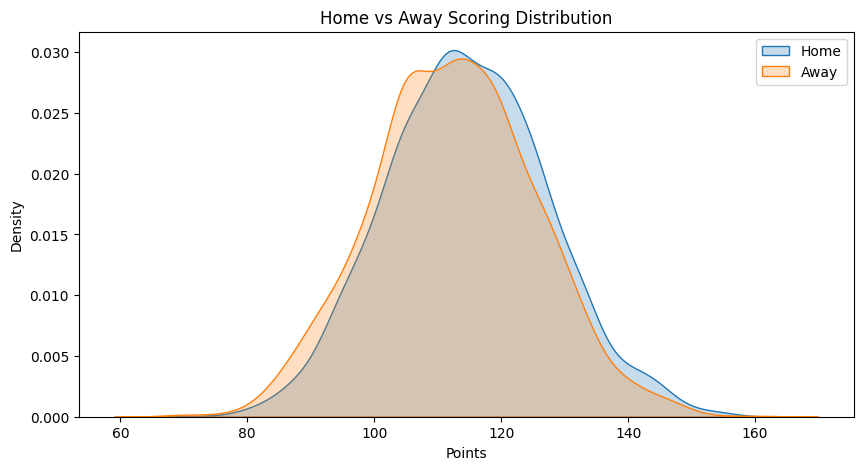

In [4]:
plt.figure(figsize=(10,5))
sns.kdeplot(final_df["home_PTS"], label="Home", fill=True)
sns.kdeplot(final_df["away_PTS"], label="Away", fill=True)
plt.title("Home vs Away Scoring Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

In [5]:
numeric_df = final_df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

reduced_df = final_df.drop(columns=to_drop)

print("Dropped columns:", to_drop)
print("Remaining columns:", reduced_df.columns)

Dropped columns: ['FGM_home', 'FTA_home', 'FGM_away', 'FTA_away']
Remaining columns: Index(['gameid', 'date', 'home_team', 'away_team', 'home_PTS', 'away_PTS',
       'FGA_home', 'FG%_home', '3PM_home', '3PA_home', '3P%_home', 'FTM_home',
       'FT%_home', 'OREB_home', 'DREB_home', 'REB_home', 'AST_home',
       'TOV_home', 'STL_home', 'BLK_home', 'PF_home', 'FGA_away', 'FG%_away',
       '3PM_away', '3PA_away', '3P%_away', 'FTM_away', 'FT%_away', 'OREB_away',
       'DREB_away', 'REB_away', 'AST_away', 'TOV_away', 'STL_away', 'BLK_away',
       'PF_away', 'home_last5_pts', 'away_last5_pts', 'TOTAL_POINTS'],
      dtype='object')


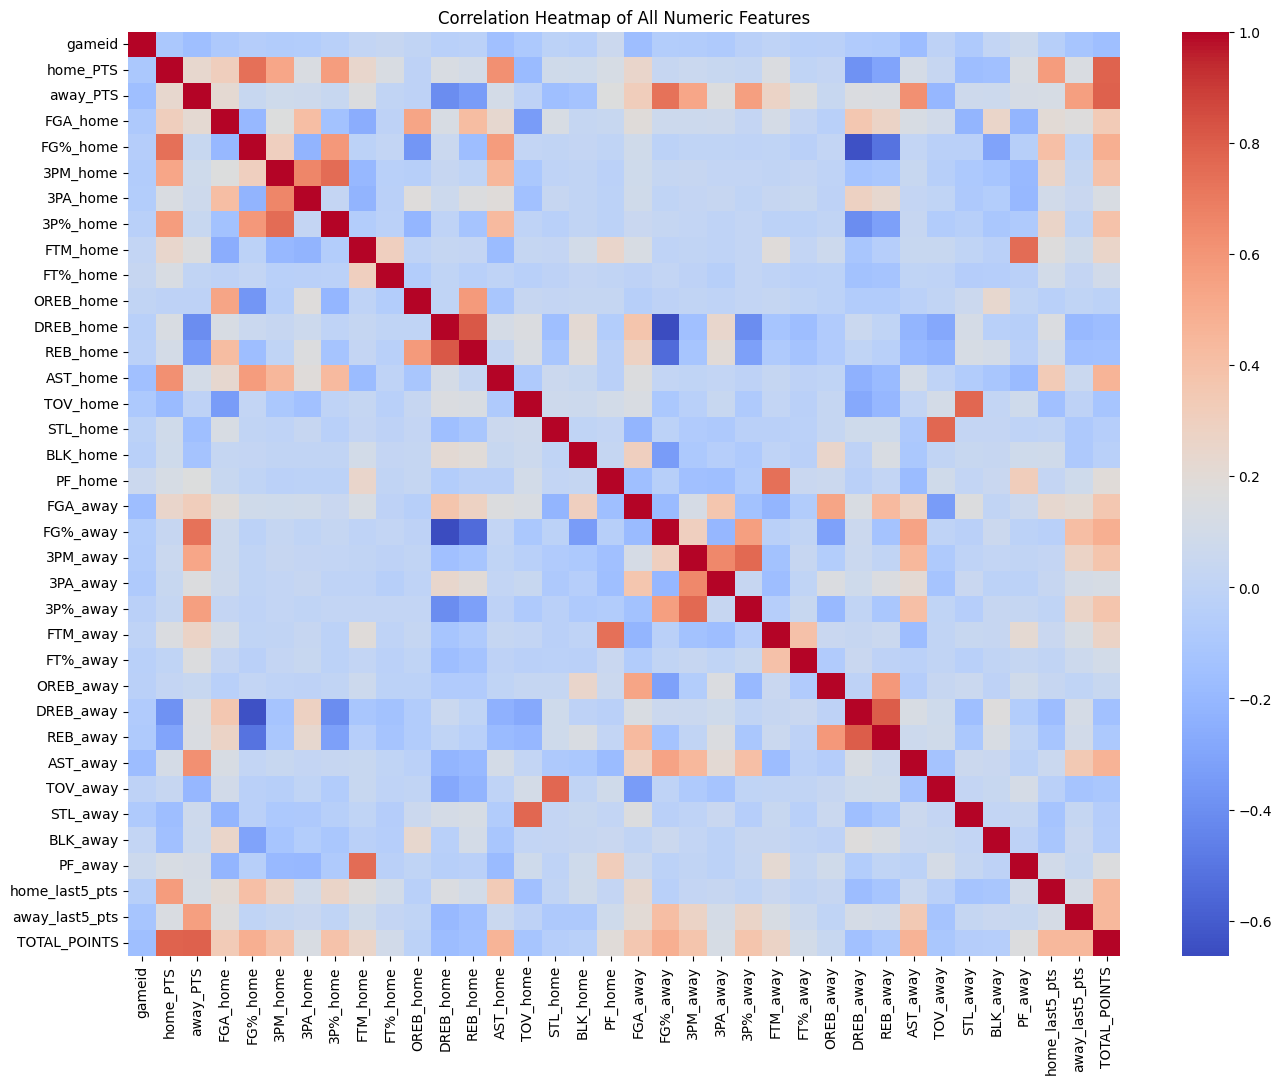

In [6]:
numeric_only = reduced_df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_only.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()